## Identifying and plotting genes which have correlated spatial/buildup scores

Correlating using the reads directly from the .bam

In [1]:
import importlib
import pandas as pd
import numpy as np
import scipy.stats
from statsmodels.stats import multitest
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import math
import glob
import os

import sprawl
from sprawl import plotting, utils
import importlib

## ReadZs scores for gene 3' UTRs

1. Specifying BAM path to get ReadZs scores from
2. Processing GTF to get 3' UTR positions
3. Matching gene names from MERFISH to the GTF to subset to just the regions of interest
4. Creating a table of ReadZs scores per ontology for each locus

In [2]:
%%time
#creating subsetted gtf to prepare for ReadZs score extraction

#this bam is from Tabula Muris has cell-type as XO tag
bam_path = '../../inputs/TabulaMuris_Liver_Kidney.bam'
    
#mouse gtf file to be able to plot exons/UTRs
full_gtf = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/sprawl/inputs/gencode.vM23.annotation.gtf',
    comment = '#',
    sep = '\t',
    header = None,
    names = ['chrom','source','kind','start','end','dot1','strand','dot2','info'],
)
gtf = full_gtf[full_gtf['kind'].isin(['exon','UTR'])]
gtf['label'] = gtf['info'].str.extract('gene_name "(.*?)";')
gtf['group'] = gtf['info'].str.extract('transcript_id "(.*?)";')

#Saw these gene synonyms were used, make the gtf match the CZB gene names
synonym_gtf_to_merf = {
    'Shisal2b':'Fam159b',
    'Cyb561a3':'Cybasc3',
    'Adgre1':'Emr1',
    'Fcmr':'Faim3',
    'Adgrf5':'Gpr116',
    'Cavin1':'Ptrf',
    'Cltrn':'Tmem27',
    'H2-Ab1':'H2-ab1',
    '2210010C04Rik':'2210010c04rik',
    'H2-Aa':'H2-aa',
    'ccdc198':'1700011h14rik',
}
gtf['label'] = gtf['label'].replace(synonym_gtf_to_merf)


#Get the CZB MERFISH gene names from the gene_ont outputs
gene_ont_paths = glob.glob('../../nf_pipeline/outputs/sprawl_20220526/gene_ont/CZB_*')
CZB_genes_df = pd.concat((pd.read_csv(p, usecols=['gene']) for p in gene_ont_paths), ignore_index=True)
CZB_genes = set(CZB_genes_df['gene'])

#sanity checking gene labels match between GTF and spatial
#Determine how many genes are present in both the gtf and the gene/cell table
gtf_genes = set(gtf['label'])
shared_genes = CZB_genes.intersection(gtf_genes)
CZB_only_genes = CZB_genes.difference(gtf_genes)

print('There are',len(gtf_genes),'unique genes in the gtf')
print('There are',len(CZB_genes),'unique genes in the gene/cell table')
print('There are',len(shared_genes),'genes shared between both')
print('Genes present only in the gene/cell table',CZB_only_genes)

#subset the gtf to just the entries with the shared genes
gtf = gtf[gtf['label'].isin(shared_genes)]

#have to 'manually' distinguish between 5' and 3' UTRs
for (transcript_id,strand),t in gtf.groupby(['group','strand']):
    if strand == '+':
        utr3_start = t[t['kind'].eq('exon')]['end'].max()
        utr_3s = t[t['kind'].eq('UTR') & t['end'].ge(utr3_start)]
    elif strand == '-':
        utr3_start = t[t['kind'].eq('exon')]['start'].min()
        utr_3s = t[t['kind'].eq('UTR') & t['start'].le(utr3_start)]
    else:
        sys.stderr.write('strand error\n')
        break
        
    gtf.loc[utr_3s.index,'kind'] = '3UTR'


#Determine which loci to plot by:
#1) selecting genes that are in both the gtf and the gene/cell table
#2) selecting on UTRs
#3) grouping by gene and expanding left to the 5'-most UTR start, and right to the 3'-most UTR end
#   this is important for genes with multiple annotated 3' UTRs
#4) add a bit of "padding" on either side of the locus as 1% of the span
loci = gtf[
    gtf['label'].isin(shared_genes) &
    gtf['kind'].eq('3UTR')
][['label','chrom','start','end','strand']].drop_duplicates()

loci = loci.groupby(['label','chrom','strand']).agg(
    start = ('start','min'),
    end = ('end','max'),
).reset_index()

padding = loci['end'].subtract(loci['start']).multiply(0.01).astype(int)
loci['start'] -= padding
loci['end'] += padding

print('There are',len(loci),'loci to use for plotting')

There are 55228 unique genes in the gtf
There are 307 unique genes in the gene/cell table
There are 307 genes shared between both
Genes present only in the gene/cell table set()
There are 305 loci to use for plotting
CPU times: user 13.2 s, sys: 764 ms, total: 13.9 s
Wall time: 15 s


In [3]:
%%time
#perform the ReadZs proxy scoring for each locus of interest for each ontology
importlib.reload(utils)
data = collections.defaultdict(list)

for _,l in loci.iterrows():
    readzs_scores = utils.readzs_proxy_score(
        bam_path,
        locus = (l.chrom, l.start, l.end),
        strand = l.strand, #select only reads on this specific strand
        stratify_tag = 'XO',
        min_tag_reads = 10, #require at least x reads for an ontology to be included (over any number of cells)
    )

    for ontology,readzs_proxy in readzs_scores.items():
        data['gene'].append(l.label)
        data['ontology'].append(ontology)
        data['locus'].append((l.chrom,l.start,l.end,l.strand))
        data['chrom'].append(l.chrom)
        data['start'].append(l.start)
        data['end'].append(l.end)
        data['strand'].append(l.strand)
        data['readzs_proxy'].append(readzs_proxy)
    
median_readzs_scores = pd.DataFrame(data)
median_readzs_scores

CPU times: user 2min 9s, sys: 2.38 s, total: 2min 11s
Wall time: 2min 23s


,gene,ontology,locus,chrom,start,end,strand,readzs_proxy
0,Abcc8,podocyte,"(chr7, 46103814, 46176190, -)",chr7,46103814,46176190,-,-0.384271
1,Ace2,epithelial cell of proximal tubule,"(chrX, 164187590, 164188428, +)",chrX,164187590,164188428,+,0.367542
2,Ace2,hepatic stellate cell,"(chrX, 164187590, 164188428, +)",chrX,164187590,164188428,+,0.310263
3,Ace2,kidney distal convoluted tubule epithelial cell,"(chrX, 164187590, 164188428, +)",chrX,164187590,164188428,+,0.331742
4,Ace2,podocyte,"(chrX, 164187590, 164188428, +)",chrX,164187590,164188428,+,0.369928
...,...,...,...,...,...,...,...,...
2570,Zap70,NK cell,"(chr1, 36782580, 36782820, +)",chr1,36782580,36782820,+,-0.633333
2571,Zap70,lymphocyte,"(chr1, 36782580, 36782820, +)",chr1,36782580,36782820,+,-0.666667
2572,Zap70,other hepatocyte,"(chr1, 36782580, 36782820, +)",chr1,36782580,36782820,+,-0.608333
2573,Zap70,pericentral hepatocyte,"(chr1, 36782580, 36782820, +)",chr1,36782580,36782820,+,-0.608333


In [4]:
median_readzs_scores['ontology'].value_counts()

Kupffer cell                                       244
kidney distal convoluted tubule epithelial cell    219
epithelial cell of proximal tubule                 215
podocyte                                           214
other endothelial cell                             210
lymphocyte                                         195
kidney collecting duct epithelial cell             193
macrophage                                         188
NK cell                                            174
glomerular capillary endothelial cell              158
hepatic stellate cell                              154
pericentral hepatocyte                             151
other hepatocyte                                   151
periportal hepatocyte                              109
Name: ontology, dtype: int64

# Correlate median Readzs proxy values to median spatial scores

Correct for multiple testing over all metrics (conservative?)

There aren't any significantly correlated genes after BH correction(!)


In [5]:
%%time
#read in all gene/ont info for both mice over all metrics
all_BICCN_gene_onts = glob.glob('../../nf_pipeline/outputs/sprawl_20220526/gene_ont/CZB_*')
gene_ont_df = pd.concat((pd.read_csv(p) for p in all_BICCN_gene_onts))

data = collections.defaultdict(list)

for (gene,metric),sg in gene_ont_df.groupby(['gene','metric']):
           
    sg = sg.groupby('annotation')['med_score'].median().reset_index() #averaging over both mice

    readzs_df = median_readzs_scores[median_readzs_scores['gene'].eq(gene)]
    
    for locus,rg in readzs_df.groupby('locus'):
    
        shared_onts = list(set(sg['annotation']).intersection(rg['ontology']))
    
        #skip spatial/read-buildup correlations that have fewer x shared ontologies
        if len(shared_onts) < 4:
            continue
            
        sg_scores = sg.set_index('annotation').loc[shared_onts,'med_score']
        rg_scores = rg.set_index('ontology').loc[shared_onts,'readzs_proxy']
        
        r,p = scipy.stats.pearsonr(sg_scores, rg_scores)
        
        data['gene'].append(gene)
        data['metric'].append(metric)
        data['locus'].append(locus)
        data['num_shared_onts'].append(len(shared_onts))
        data['span_spatial'].append(sg_scores.max()-sg_scores.min())
        data['span_readzs'].append(rg_scores.max()-rg_scores.min())
        data['r'].append(r)
        data['p'].append(p)
    
corr_df = pd.DataFrame(data).dropna() #some NaN's because an input array is constant to the Pearson corr

#BH multiple hypothesis testing
passes,adj_p,_,_ = multitest.multipletests(
    corr_df['p'],
    alpha = 0.05,
    method = 'fdr_bh',
)
corr_df['bh_p'] = adj_p
corr_df['significant'] = passes

corr_df.sort_values('p')

CPU times: user 3.55 s, sys: 5.01 ms, total: 3.56 s
Wall time: 3.62 s


,gene,metric,locus,num_shared_onts,span_spatial,span_readzs,r,p,bh_p,significant
94,Clu,periph,"(chr14, 65975522, 65981606, +)",11,0.090171,0.104536,-0.821026,0.001949,0.448079,False
173,Gas1,periph,"(chr13, 60174392, 60175802, -)",10,0.143577,0.082979,0.845864,0.002041,0.448079,False
351,Ptgis,periph,"(chr2, 167191690, 167203441, -)",6,0.159223,0.007829,-0.953917,0.003136,0.458972,False
89,Cldn3,radial,"(chr5, 134987099, 134987475, +)",7,0.392000,0.148936,-0.907628,0.004737,0.519838,False
42,Btnl9,periph,"(chr11, 49165551, 49169090, -)",9,0.194710,1.531224,-0.826277,0.006044,0.529516,False
...,...,...,...,...,...,...,...,...,...,...
236,Irf8,periph,"(chr8, 120755158, 120756709, +)",10,0.235555,1.410703,0.003694,0.991919,0.997465,False
167,Flt1,radial,"(chr5, 147560829, 147639907, -)",4,0.501000,1.159235,-0.003674,0.996326,0.997465,False
307,Nudt4,radial,"(chr10, 95546985, 95549312, -)",8,0.234000,0.035239,0.001812,0.996602,0.997465,False
164,Fcgr2b,radial,"(chr1, 170958594, 170961039, -)",4,0.542000,0.033538,0.002788,0.997212,0.997465,False


In [6]:
%%time
#Measure how different the ReadZs buildups are for the significant gene/loci to prioritize those genes
#using variance between ontologies as the measure, but I don't know if this is normalized for different numbers of 
#ontologies or different sized windows
gene_locus_var = {}

for _,r in corr_df.iterrows():
    chrom,start,end,strand = r.locus
    read_pos_df = utils.bam_read_positions(
        bam_path,
        locus = (chrom, start, end),
        strand = strand,
        stratify_tag = 'XO',
        min_tag_reads = 100, #require at least x reads for an ontology to be included (over any number of cells)
    )
    
    if read_pos_df.empty:
        continue

    #Bin the read_pos_df
    min_pos,max_pos = read_pos_df['pos'].min(),read_pos_df['pos'].max()
    span = max_pos-min_pos
    num_windows = min(span,100)
    bin_size = math.ceil(span/num_windows)
    bins = np.arange(min_pos,max_pos+bin_size,bin_size)
    read_pos_df['bin'] = pd.cut(read_pos_df['pos'],bins=bins,labels=bins[:-1],right=False)

    #Calculate the CDFs using the bins
    read_bin_df = read_pos_df.groupby(['strat','bin'])['pos'].count().reset_index()
    wide_df = read_bin_df.pivot(
        index='bin',
        columns='strat',
        values='pos',
    )
    wide_df = wide_df.cumsum().div(wide_df.sum())
    
    #Find the avg variance over all bins
    cdf_var = wide_df.var(axis=1).sum()/num_windows
    gene_locus_var[(r.gene,r.locus)] = cdf_var
    

#Add a new column to the corr_df of the mean variances
gene_locus_var = pd.Series(gene_locus_var)
corr_df = corr_df.set_index(['gene','locus'])
corr_df['readzs_var'] = gene_locus_var
corr_df = corr_df.reset_index()
corr_df.sort_values('readzs_var',ascending=False)

CPU times: user 5min 21s, sys: 4.78 s, total: 5min 26s
Wall time: 5min 26s


,gene,locus,metric,num_shared_onts,span_spatial,span_readzs,r,p,bh_p,significant,readzs_var
347,Prlr,"(chr15, 10329066, 10349379, +)",periph,9,0.134777,1.355880,0.139772,0.719854,0.972112,False,0.056040
348,Prlr,"(chr15, 10329066, 10349379, +)",puncta,8,0.976000,1.355880,0.066452,0.875768,0.994295,False,0.056040
349,Prlr,"(chr15, 10329066, 10349379, +)",radial,8,0.456000,1.355880,-0.795621,0.018205,0.631783,False,0.056040
119,Cx3cr1,"(chr9, 119900120, 120052768, -)",periph,5,0.101937,1.599549,0.114174,0.854946,0.992866,False,0.044481
172,Foxc1,"(chr13, 31808831, 31812512, +)",periph,4,0.083652,0.318392,-0.644600,0.355400,0.936425,False,0.030407
...,...,...,...,...,...,...,...,...,...,...,...
1,Acta2,"(chr19, 34241085, 34241674, -)",puncta,4,0.430000,0.190153,-0.847257,0.152743,0.901205,False,0.000000
0,Acta2,"(chr19, 34241085, 34241674, -)",periph,5,0.018818,0.190153,-0.894830,0.040290,0.769021,False,0.000000
251,Krt18,"(chr15, 102031959, 102032027, +)",periph,4,0.029077,0.294118,-0.768687,0.231313,0.927438,False,NaN
252,Krt18,"(chr15, 102031959, 102032027, +)",puncta,4,0.242000,0.294118,-0.041722,0.958278,0.994295,False,NaN


In [7]:
corr_df[corr_df['significant']]['gene'].unique()

array([], dtype=object)

# Plotting

In [8]:
#read in all gene/cell info for both mice over all metrics (this is a large table)
all_BICCN_gene_cells = glob.glob('../../nf_pipeline/outputs/sprawl_20220526/gene_cell/CZB_*.csv')
gene_cell_df = pd.concat((
    pd.read_csv(p, usecols=['metric','annotation','gene','score'])
    for p in all_BICCN_gene_cells
))
gene_cell_df

,metric,annotation,gene,score
0,radial,pericentral hepatocyte,Igfbp4,0.826000
1,radial,pericentral hepatocyte,Vtn,-0.320000
2,radial,pericentral hepatocyte,Cldn3,-0.400000
3,radial,pericentral hepatocyte,Ces3a,0.468000
4,radial,pericentral hepatocyte,Gulo,0.694000
...,...,...,...,...
514158,periph,pericentral hepatocyte,Nudt4,0.925926
514159,periph,pericentral hepatocyte,Fmo1,0.481481
514160,periph,pericentral hepatocyte,Mrc1,0.444444
514161,periph,pericentral hepatocyte,Actn4,-0.305556


Making 25 plots
Prlr chr15 10329066 10349379 +


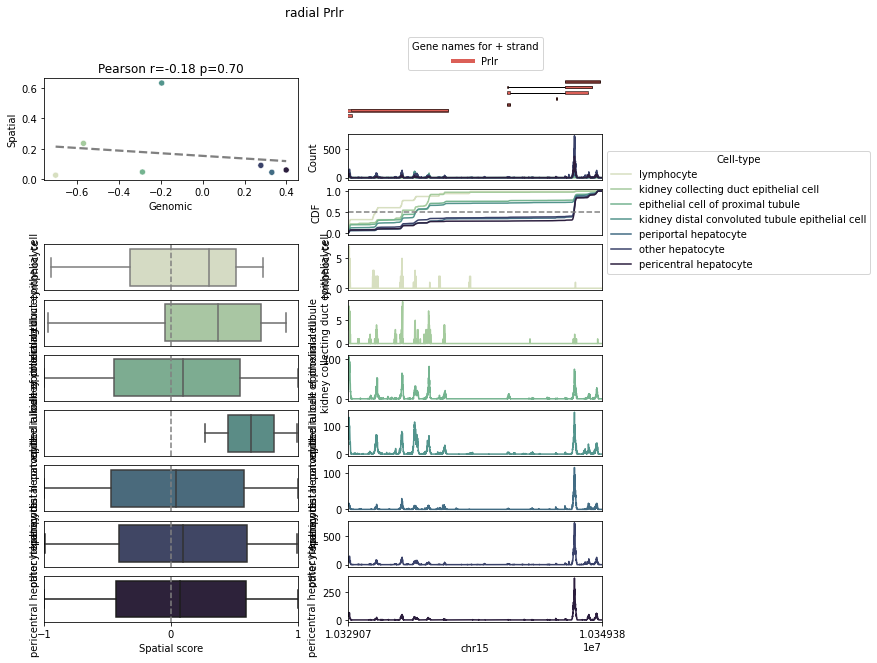

Cd300lg chr11 102054197 102055634 +


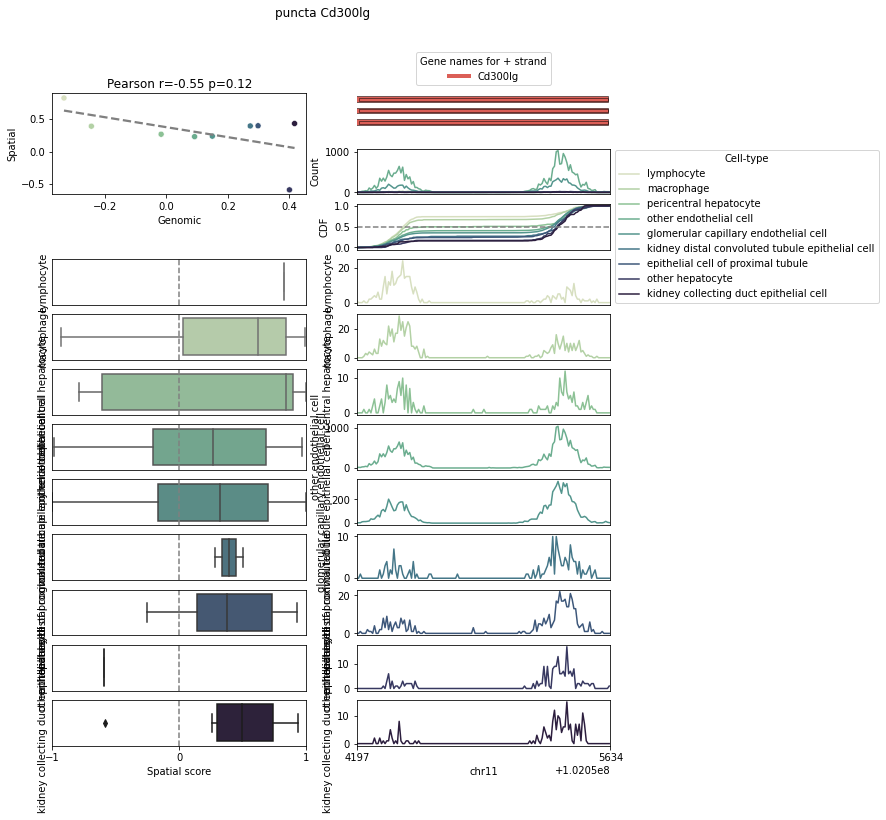

Cd300lg chr11 102054197 102055634 +


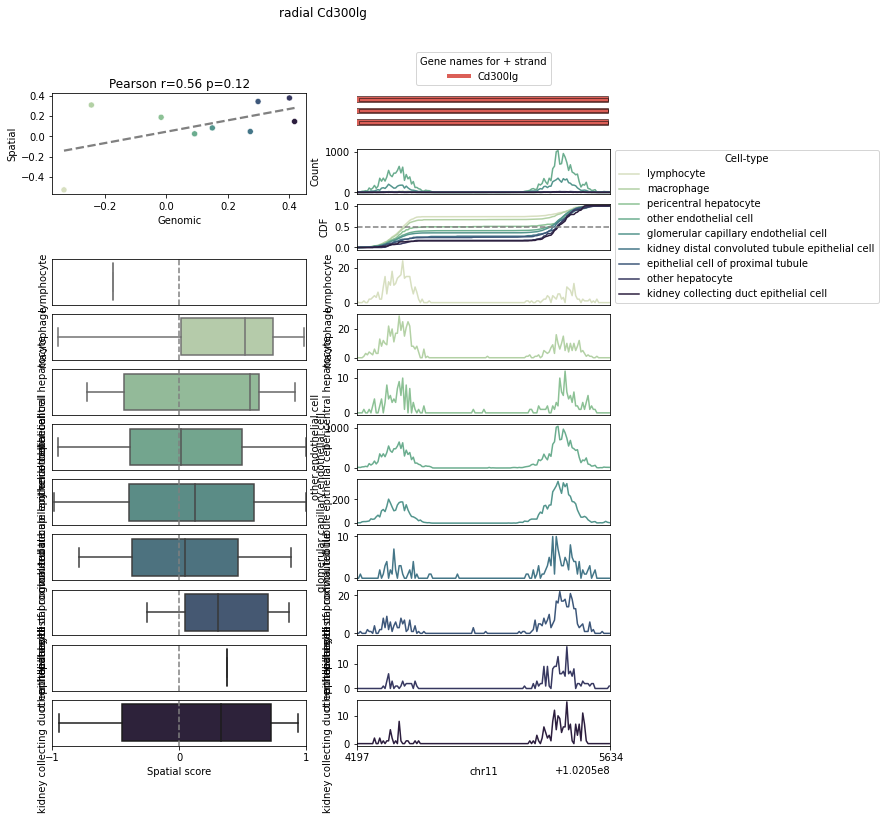

Flt1 chr5 147560829 147639907 -


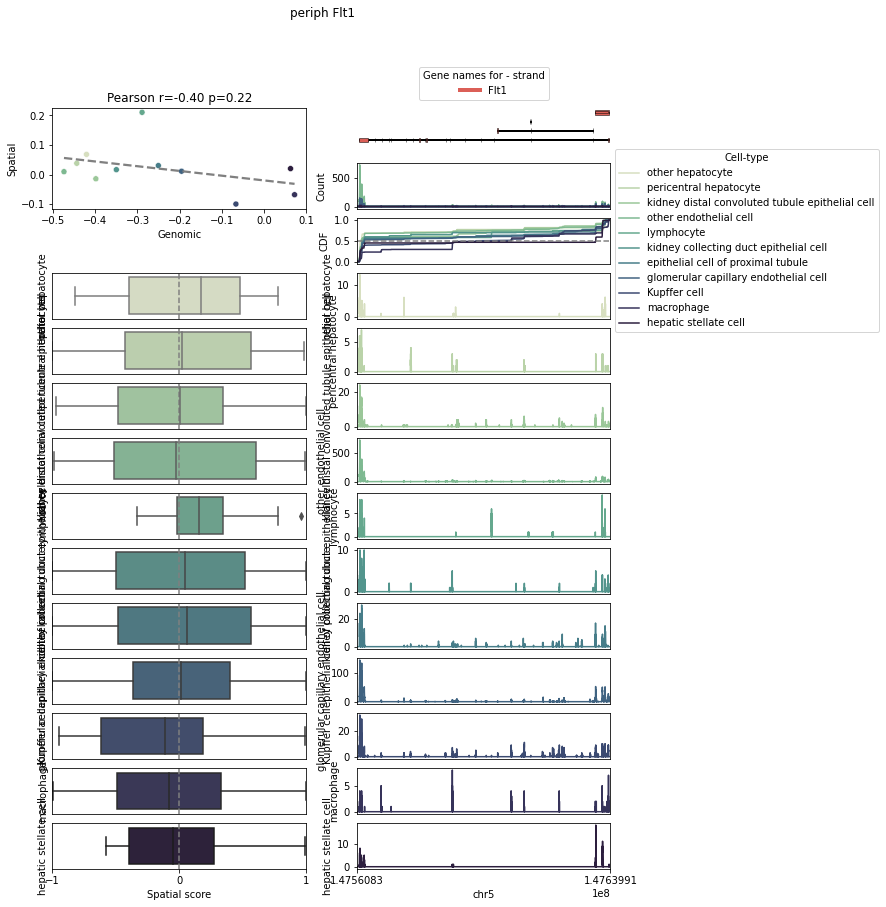

Uox chr3 146630516 146632322 +


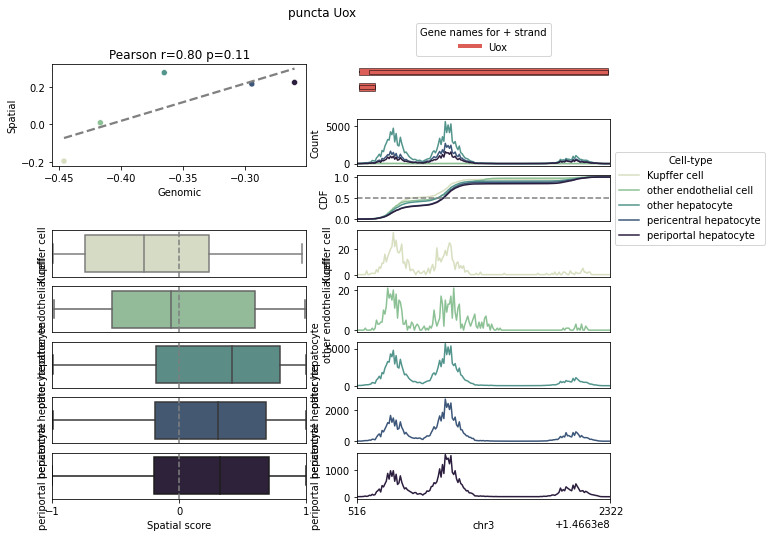

Gas1 chr13 60174392 60175802 -


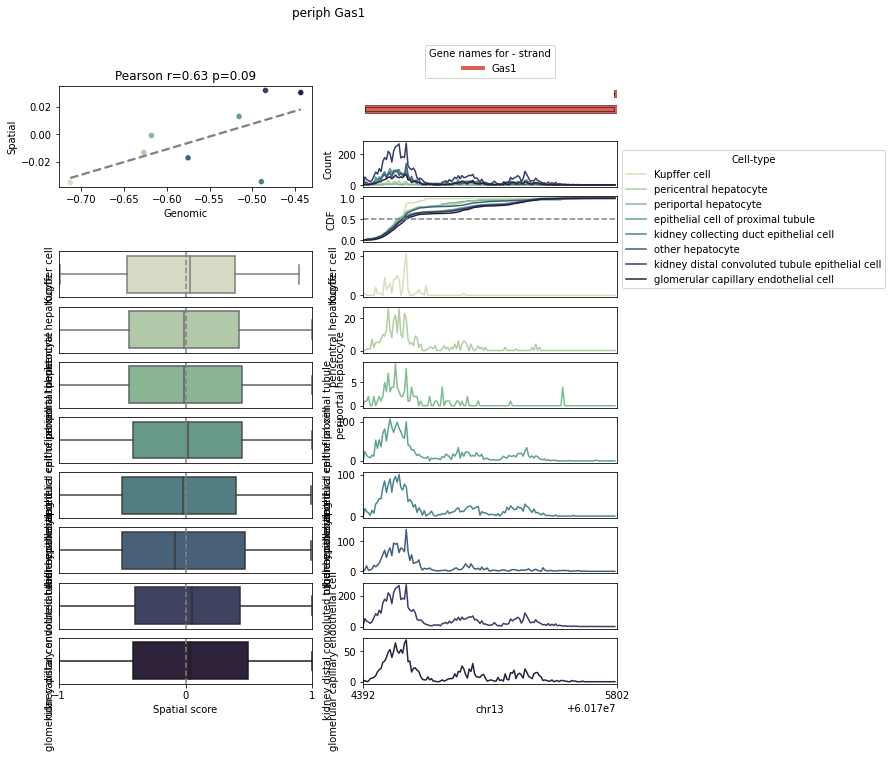

Ptgis chr2 167191690 167203441 -


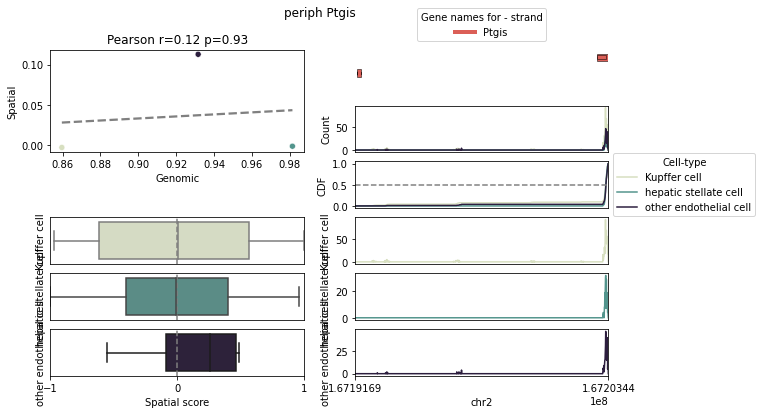

Hmgcs2 chr3 98309013 98310755 +


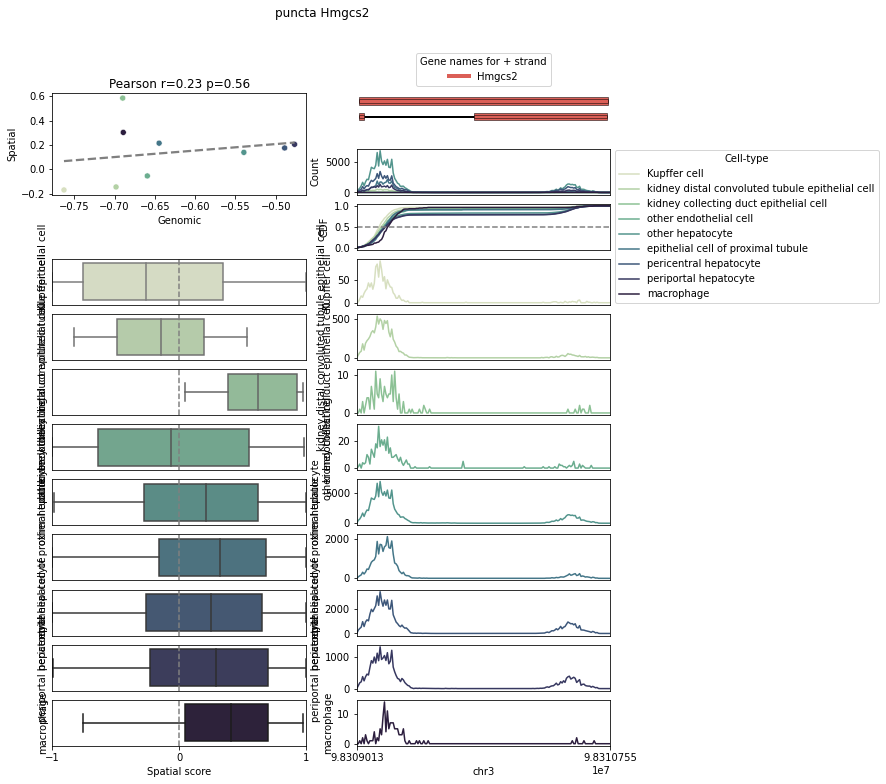

Btnl9 chr11 49165551 49169090 -


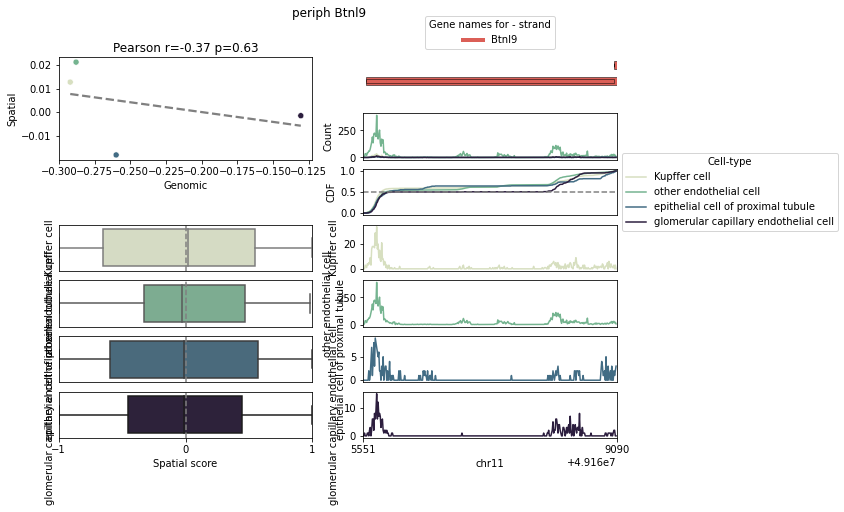

Pcolce chr5 137605103 137605165 -


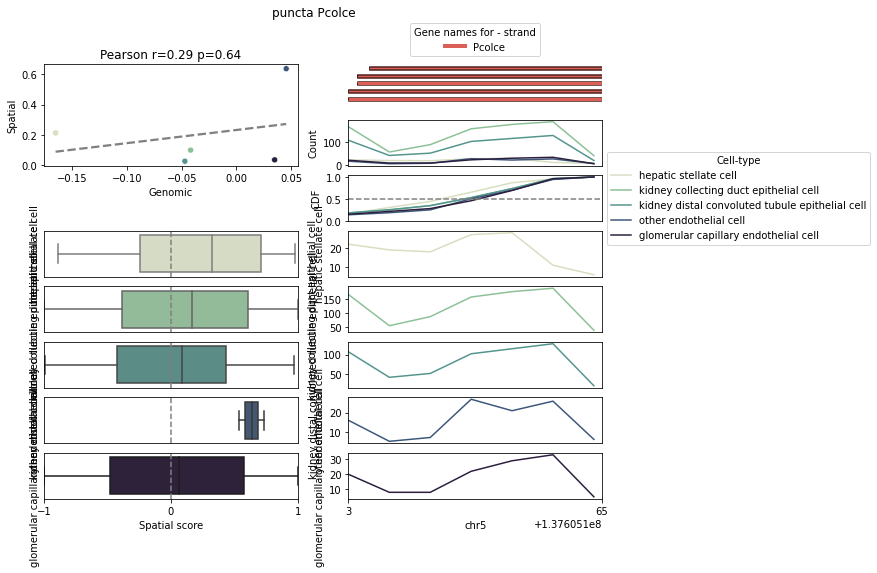

Pcolce chr5 137605103 137605165 -


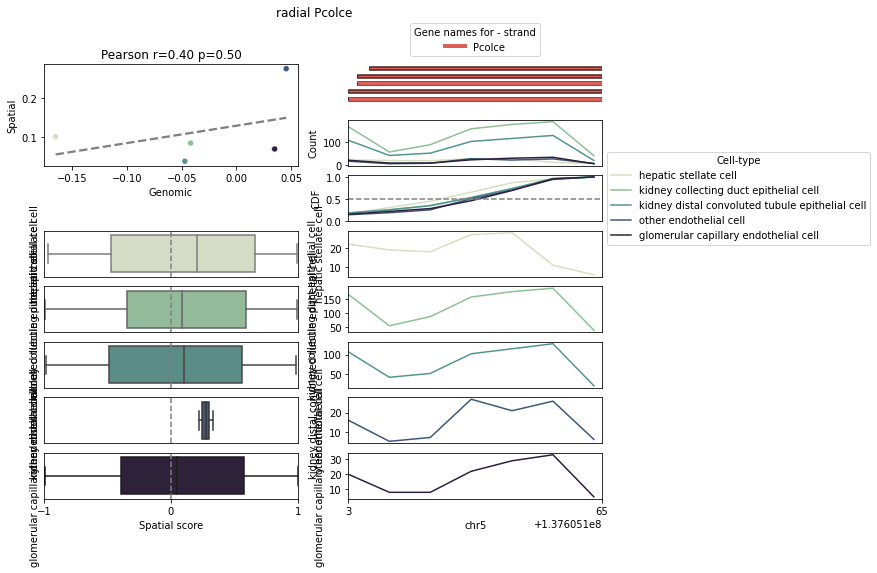

Arhgdib chr6 136923651 136924133 -


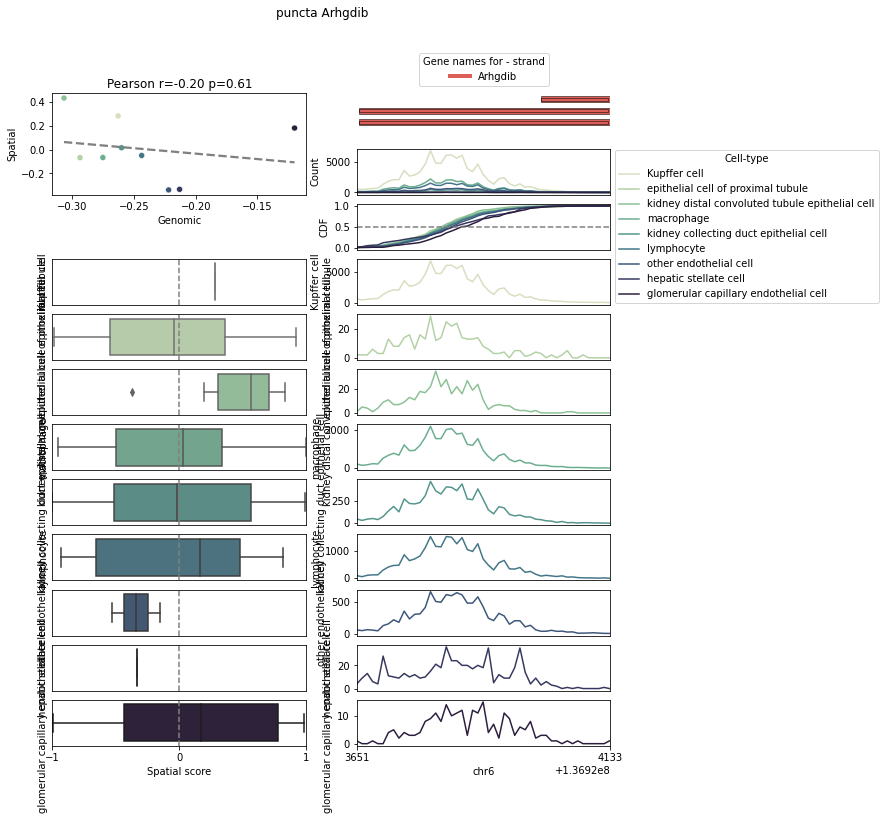

Clu chr14 65975522 65981606 +


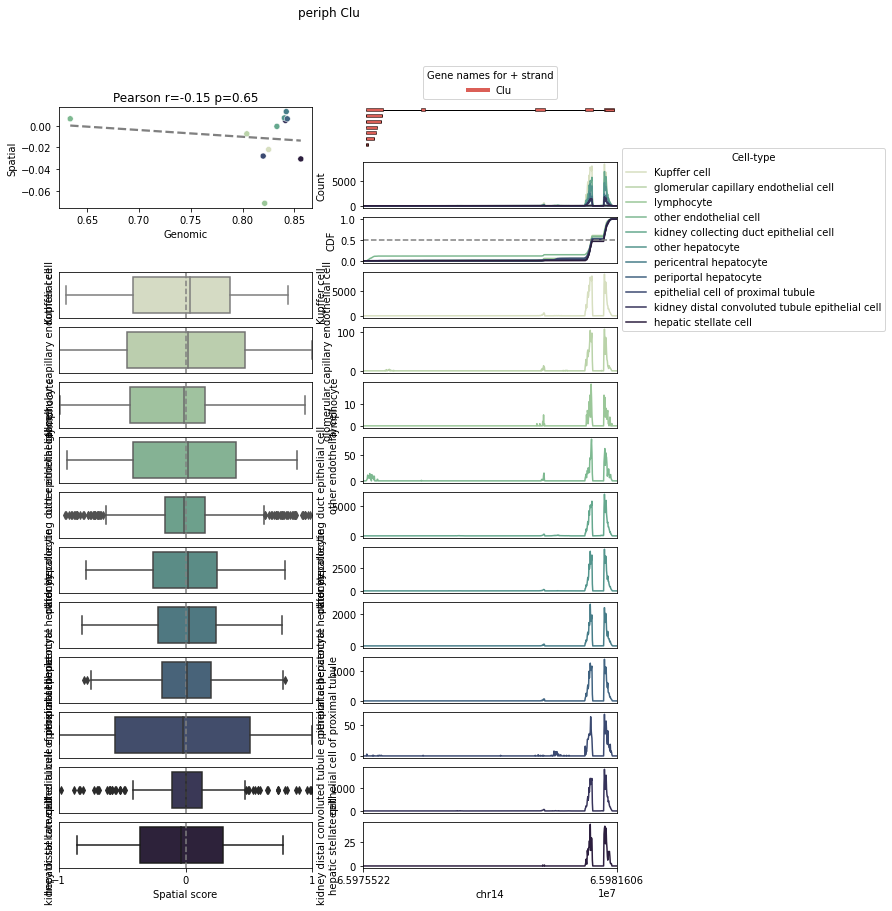

Cdh5 chr8 104142981 104144526 +


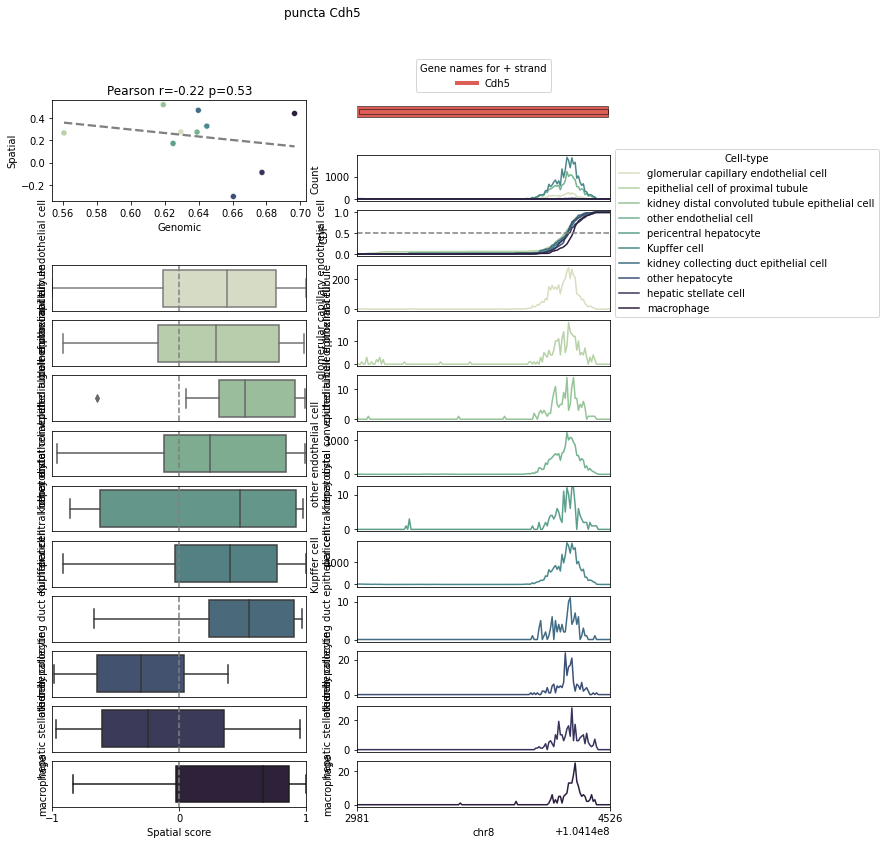

Alox5ap chr5 149287728 149288157 +


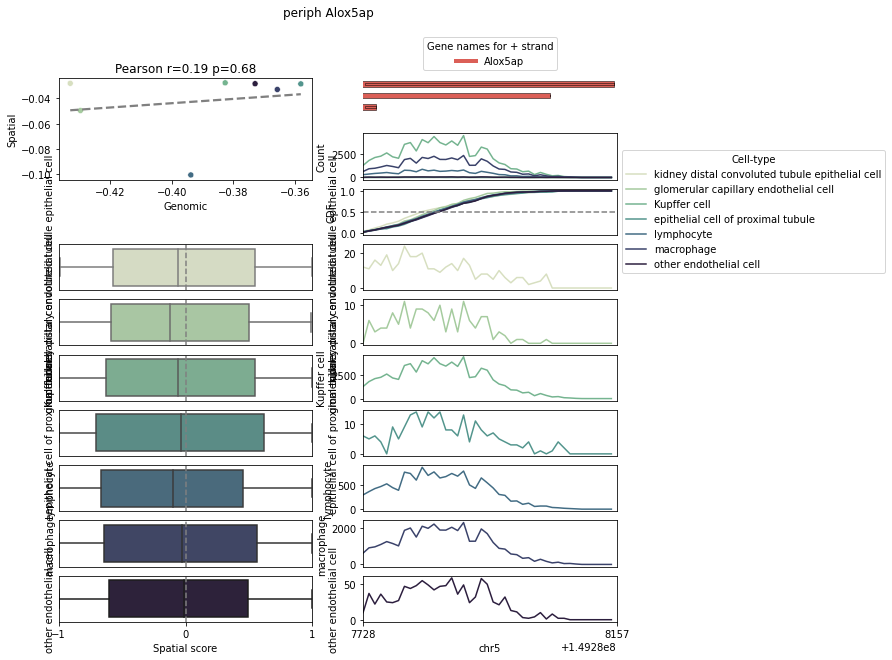

Bbox1 chr2 110262670 110265483 -


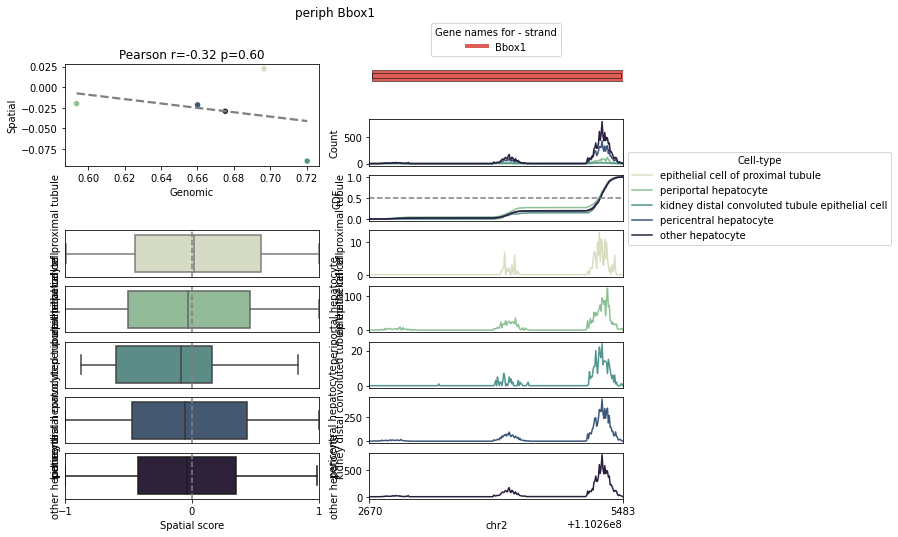

Scnn1a chr6 125343687 125344955 +


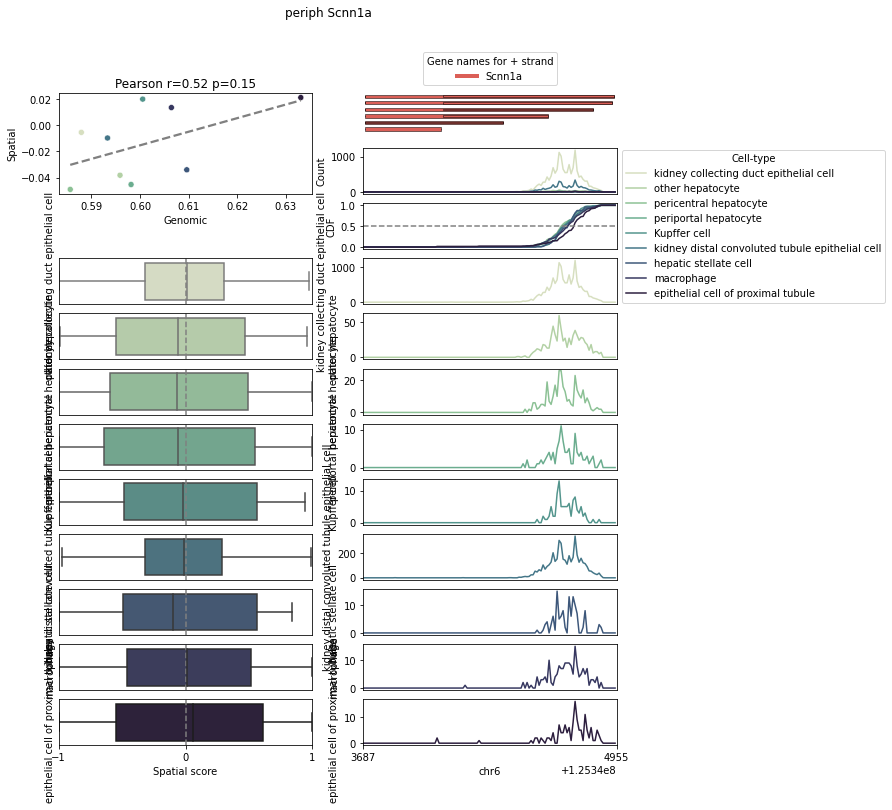

Scnn1a chr6 125343687 125344955 +


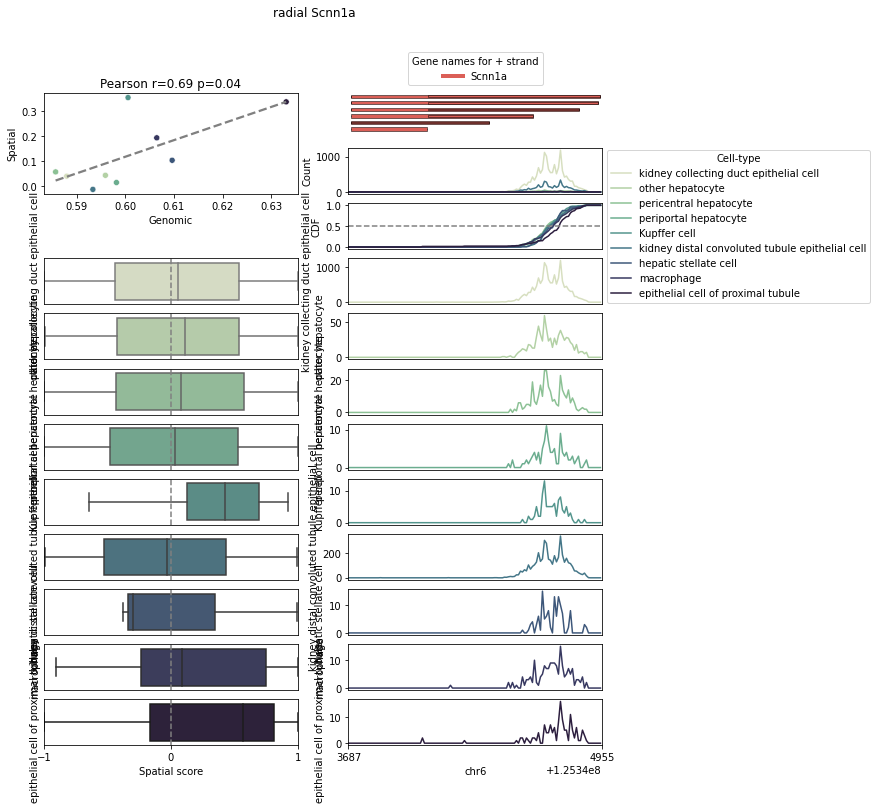

Fmo1 chr1 162829447 162841116 -


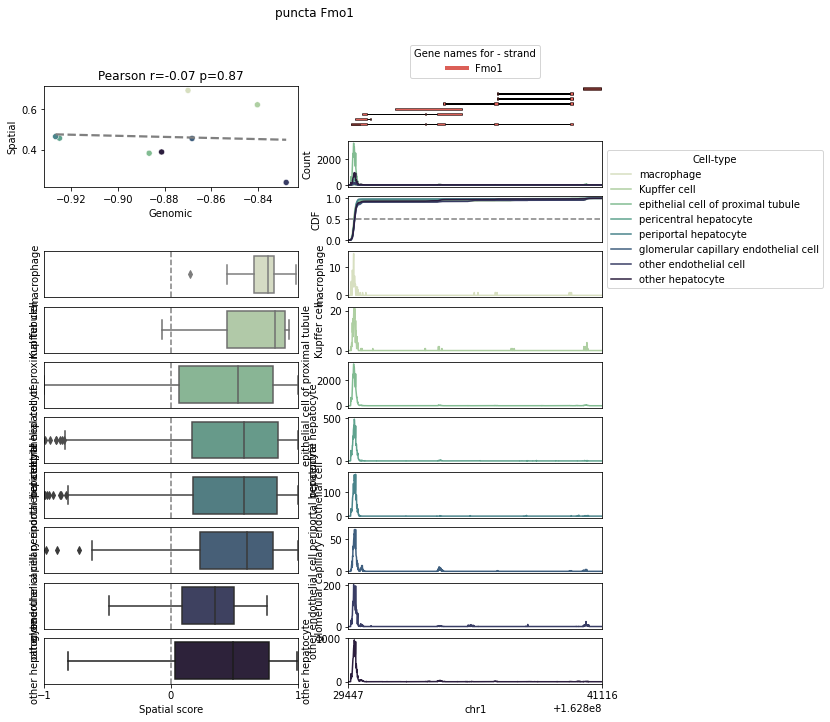

Fmo1 chr1 162829447 162841116 -


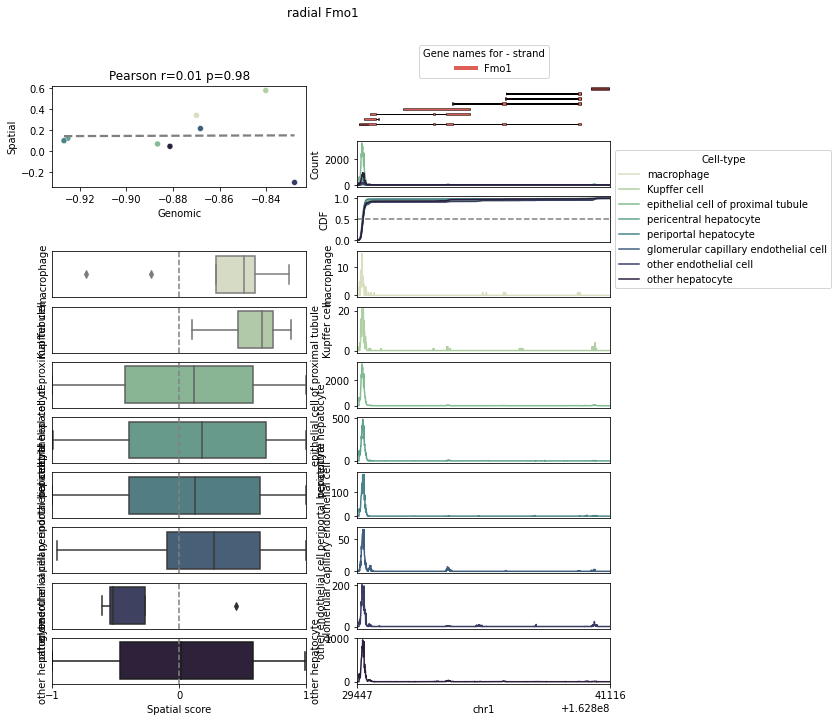

Cyp2f2 chr7 27133393 27133662 +


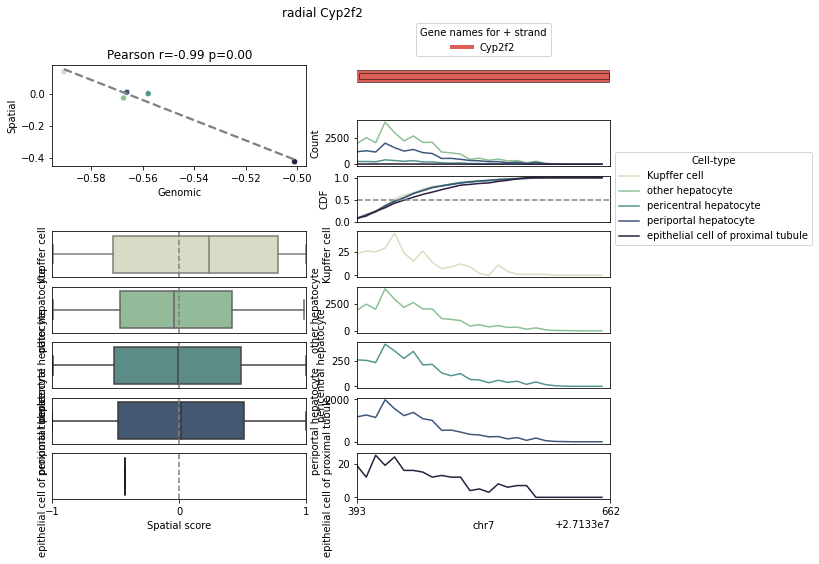

Lgals3 chr14 47385674 47386164 +


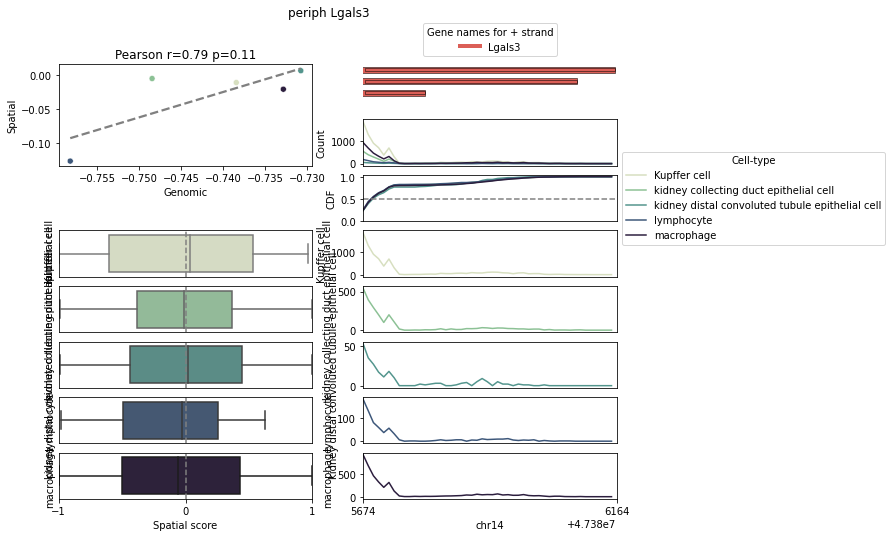

Cldn3 chr5 134987099 134987475 +


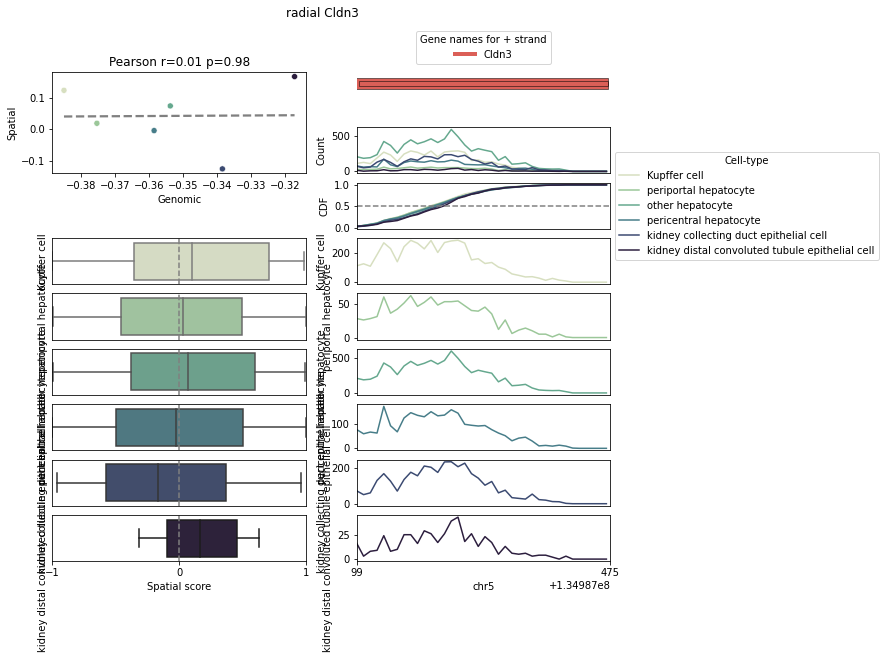

Ak4 chr4 101463632 101467028 +


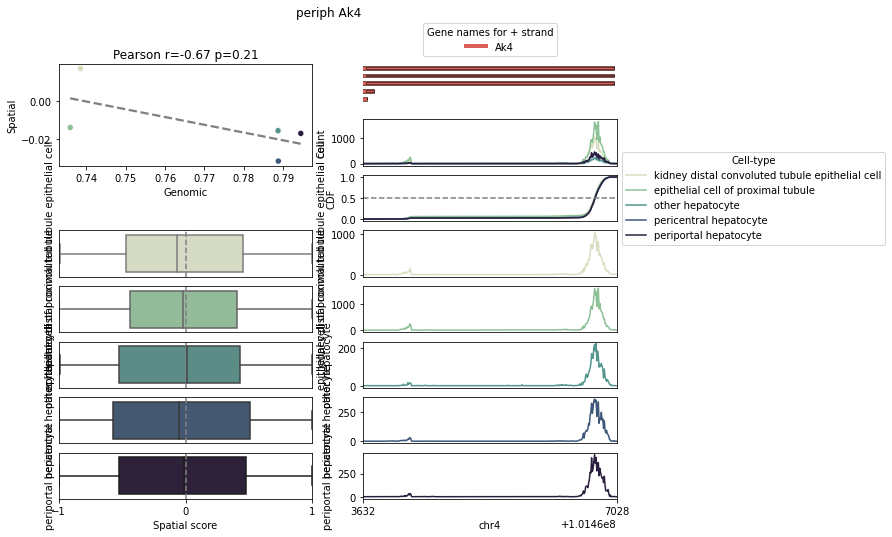

Acta2 chr19 34241085 34241674 -


<Figure size 432x288 with 0 Axes>

In [9]:
#Plotting
#Plot significant metric/gene combinations making buildup plots
importlib.reload(plotting)

plot_df = corr_df[
    corr_df['p'].le(0.05) #NOTE, using p instead of bh_p because no gene was sig after BH
].sort_values('readzs_var',ascending=False)

print('Making',len(plot_df),'plots')

pdf = plotting.make_pdf('CZB_spatial_readzs_corrs_10Xv3.pdf')

for i,r in plot_df.iterrows():
    
    spatial_df = gene_cell_df[
        gene_cell_df['gene'].eq(r.gene)
        & gene_cell_df['metric'].eq(r.metric)
    ]

    chrom,start,end,strand = r.locus
    print(r.gene,chrom,start,end,strand)
    fig = plotting.read_buildup_plot(
        bam_path, locus=(chrom,start,end), strand=strand,
        ann_df=gtf, spatial_df=spatial_df,
        stratify_tag='XO', 
        ws=10, min_tag_reads=100,
    )
    
    my_suptitle = plt.suptitle(f'{r.metric} {r.gene}')
    pdf.savefig(fig, bbox_inches='tight', bbox_extra_artists=[my_suptitle])
    plt.show(fig)
    plt.close()
    
pdf.close()